# T2. COLUMN DETECTION

## LIBRARIES

In [1]:
#IMPORT PACKAGES
import os.path
from pathlib import Path
import numpy as np
import open3d as o3d

import random as rd
import pandas as pd
import cv2
import laspy
import json
from scipy.spatial.transform import Rotation   
import copy
from datetime import datetime

import geomapi
from geomapi.nodes import *
from geomapi import utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt

import geomapi.tools as tl

import context
import utils as utl
import utils.t0_utils as t0
import utils.t2_utils as t2

import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## INPUTS

define inputs

In [4]:
path=Path(os.getcwd()).parents[2]/'data'

input_folder=path / 't0'/'test'

output_folder= path/'t2'/'inputs'
output_folder.mkdir(parents=True, exist_ok=True)
json_file = output_folder / 'image_information.json'


results_folder = path/'t2'/'test'
results_folder.mkdir(parents=True, exist_ok=True)
pixel_resolution = 0.02  # 2 cm per pixel

#column filtering
threshold_inference=0.05#detection rate
threshold_distance_min=4#m
threshold_distance_max=10#m
threshold_angle=0.99#cosine of angle
threshold_point_count=20000
weight_threshold_point_count=1/3
threshold_confidence=0.5
weight_threshold_confidence=1/3
threshold_confidence_t1=0.5
weight_threshold_confidence_t1=1/3
threshold_score=0.5

load model

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="MnzO68xYNrI0AgdgfS89") #api key to public model
project = rf.workspace().project("columns1")
model = project.version('1').model

loading Roboflow workspace...
loading Roboflow project...


## CREATE ORTHO IMAGERY OF PCD

load point cloud and produce ortho images

In [6]:
files=[f for f in utl.get_list_of_files(input_folder, '.laz') if 'small' in f]

In [7]:
# data = {}
# for f in files:
#     #read pcd
#     print(f)
#     las=laspy.read(f)
#     #create top view image
#     image, offset_x, offset_y, pixel_resolution=t2.create_top_view_point_cloud_image(las, pixel_resolution=0.02)
    
#     #store a json with the offset and the pixel resolution for every image that we proces
#     data[ut.get_filename(f)] = {
#     'offset_x': offset_x,
#     'offset_y': offset_y,
#     'pixel_resolution': pixel_resolution,
#     'x':[las.x.min(),las.x.max()],
#     'y':[las.y.min(),las.y.max()],
#     'z':[las.z.min(),las.z.max()]
#     }
#     image_path = output_folder / f'{ut.get_filename(f)}.png'
#     cv2.imwrite(str(image_path), image)
    
    
# #write json with image information
# with open(json_file, 'w') as f:
#     json.dump(data, f,indent=4)

In [8]:
# #plot an image using matplotlib
# plt.imshow(image)
# plt.show()

## INFERENCE

(upload produced imagery to roboflow to train the model some more)

load images

In [9]:
#load images and their information
image_files=[f for f in utl.get_list_of_files(output_folder, '.png') ]
with open(json_file, 'r') as file: image_json = json.load(file)

imageNodes=[]
for f in image_files:
    #cv 2 read image
    image = cv2.imread(str(f))
    n=ImageNode(resource=image, 
                name=ut.get_filename(f))
    
    #retrieve the image information matching the file_name
    image_information = next((v for k,v in image_json.items() if k in f), None)
    if image_information is not None:
        n.ri=image_information['pixel_resolution']
        n.xi=image_information['x']
        n.yi=image_information['y']
        n.zi=image_information['z']
        n.offset_x=image_information['offset_x']
        n.offset_y=image_information['offset_y']
    imageNodes.append(n)

compute inference over images

In [10]:
for n in imageNodes:
    #rescale the image to the model input size (half is fine)
    n.scale=0.7
    myimage = cv2.resize(n.resource, (0,0), fx=n.scale, fy=n.scale)

    #compute predictions
    prediction_group=model.predict(myimage, confidence=threshold_inference, overlap=30).json()
    
    # Compute the 2D location using x and y coordinates
    for prediction in prediction_group['predictions']:
        xp = prediction['x']*n.ri/n.scale
        yp = (myimage.shape[0]-prediction['y'])/n.scale*n.ri     
        # yp=   prediction['y']/n.scale_y*n.ri
        wp = prediction['width']*n.ri/n.scale
        hp = prediction['height']*n.ri/n.scale
        prediction['box']=o3d.geometry.AxisAlignedBoundingBox(min_bound=[(n.offset_x+xp-wp/2),
                                                                        (n.offset_y+yp-hp/2),
                                                                        n.zi[0]],
                                                                max_bound=[(n.offset_x+xp+wp/2),
                                                                        (n.offset_y+yp+hp/2),
                                                                        n.zi[1]])
        prediction['box'].color=[1,0,0]
    n.predictions=prediction_group['predictions']

plot the results

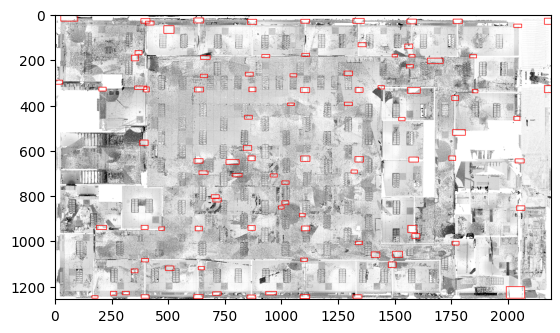

In [11]:
# n=imageNodes[0]    
#mark the detected object in the image
for n in imageNodes[0:1]:
    image=n.resource.copy()
    for prediction in n.predictions:
        x = int(prediction['x']/n.scale)
        y = int(prediction['y']/n.scale)
        width = int(prediction['width']/n.scale)
        height = int(prediction['height']/n.scale)
        cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (255, 0, 0), 2)
    plt.imshow(image)

## FILTER THE RESULTS

PointCloud with 97 points.
confidence:0.8843514323234558, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.96905
confidence:0.8294479250907898, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8262


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.7504792809486389, confidence boost for nearby axes: 0.5, confidence pcd inliers: 0.77805
confidence:0.7391254901885986, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.84145
confidence:0.7383187413215637, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.9514


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.7245215773582458, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.5528
confidence:0.6492570638656616, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.4503
confidence:0.6357744932174683, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.4598
confidence:0.6030199527740479, confidence boost for nearby axes: 0, confidence pcd inliers: 1.1064


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5935131311416626, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8893
confidence:0.5772567987442017, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.0334
confidence:0.5546529293060303, confidence boost for nearby axes: 0, confidence pcd inliers: 0.439
confidence:0.5526911616325378, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.413


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5497666597366333, confidence boost for nearby axes: 0, confidence pcd inliers: 0.8437
confidence:0.5410648584365845, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.50465
confidence:0.5390509366989136, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.75365
confidence:0.5299013257026672, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.82215


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5061783790588379, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.40765
confidence:0.47632038593292236, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.15315
confidence:0.4737696647644043, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.78085
confidence:0.45872095227241516, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.86945
confidence:0.440713107585907, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.7996
confidence:0.43014097213745117, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.8019


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.39563801884651184, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.7364
confidence:0.3923254609107971, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.70155
confidence:0.37850216031074524, confidence boost for nearby axes: 0, confidence pcd inliers: 0.2304
confidence:0.3201195299625397, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.53045


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3170318305492401, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.19795
confidence:0.3126221299171448, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.3701
confidence:0.302590548992157, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2663
confidence:0.30192530155181885, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6343
confidence:0.25404325127601624, confidence boost for nearby axes: 0, confidence pcd inliers: 0.34965
confidence:0.24271543323993683, confidence boost for nearby axes: 0, confidence pcd inliers: 0.92285


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.23870564997196198, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.8775
confidence:0.2067878246307373, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.1732
confidence:0.20411019027233124, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8375
confidence:0.20310468971729279, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.19435


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.19538907706737518, confidence boost for nearby axes: 0, confidence pcd inliers: 1.6232
confidence:0.18478631973266602, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.55885
confidence:0.1815512627363205, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.13415
confidence:0.1788705289363861, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.235
confidence:0.17724280059337616, confidence boost for nearby axes: 0, confidence pcd inliers: 0.19335
confidence:0.1733977496623993, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.4386


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.17291437089443207, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.33045
confidence:0.17058484256267548, confidence boost for nearby axes: 0, confidence pcd inliers: 0.67585
confidence:0.16745811700820923, confidence boost for nearby axes: 0, confidence pcd inliers: 1.10425
confidence:0.1606772243976593, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.0777
confidence:0.16053524613380432, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.44385
confidence:0.1524602174758911, confidence boost for nearby axes: 0, confidence pcd inliers: 0.3499
confidence:0.14717821776866913, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.3244
confidence:0.14450712502002716, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.12625
confidence:0.1438104808330536, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.6868


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.14237035810947418, confidence boost for nearby axes: 0, confidence pcd inliers: 0.6173
confidence:0.13243794441223145, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.195
confidence:0.12663742899894714, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2223
confidence:0.12165755778551102, confidence boost for nearby axes: 0, confidence pcd inliers: 0.2965


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.1212751567363739, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.5086
confidence:0.12070997059345245, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.80425
confidence:0.11942902952432632, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.61965
confidence:0.1165253221988678, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.56565
confidence:0.11483737081289291, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.2325


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.11202075332403183, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.8839
confidence:0.1111026331782341, confidence boost for nearby axes: 0, confidence pcd inliers: 0.7741
confidence:0.10840757191181183, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.61475
confidence:0.10723231732845306, confidence boost for nearby axes: 0, confidence pcd inliers: 0.4117
confidence:0.10583516955375671, confidence boost for nearby axes: 0, confidence pcd inliers: 0.90005
confidence:0.10513842105865479, confidence boost for nearby axes: 0, confidence pcd inliers: 1.49955
confidence:0.09866008907556534, confidence boost for nearby axes: 0, confidence pcd inliers: 0.51065


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09827908128499985, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.06085
confidence:0.09739626199007034, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8956
confidence:0.09724240005016327, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.3368
confidence:0.09621963649988174, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.11735


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09557511657476425, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.2042
confidence:0.09170803427696228, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.71545
confidence:0.08604460954666138, confidence boost for nearby axes: 0, confidence pcd inliers: 0.1851
confidence:0.0849863737821579, confidence boost for nearby axes: 0, confidence pcd inliers: 0.16645
confidence:0.08453936129808426, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.00855


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08434834331274033, confidence boost for nearby axes: 0, confidence pcd inliers: 0.0748
confidence:0.08368708193302155, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.5859
confidence:0.07998541742563248, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.7179
confidence:0.07936382293701172, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.963
confidence:0.07690739631652832, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.01095
confidence:0.07305946201086044, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.52015


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07282042503356934, confidence boost for nearby axes: 0, confidence pcd inliers: 0.31805
confidence:0.07240131497383118, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.63085
confidence:0.07237419486045837, confidence boost for nearby axes: 0, confidence pcd inliers: 0.33955
confidence:0.06977780908346176, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.0481


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06852108240127563, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.0474
confidence:0.06688888370990753, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8438
confidence:0.06077530235052109, confidence boost for nearby axes: 0, confidence pcd inliers: 1.03015
confidence:0.06005202606320381, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.0163


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.055066369473934174, confidence boost for nearby axes: 0, confidence pcd inliers: 0.80525
confidence:0.05480311065912247, confidence boost for nearby axes: 0.1, confidence pcd inliers: 2.39205
confidence:0.052836205810308456, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.21025
confidence:0.05238498002290726, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.7388


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.05071086809039116, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.18485
confidence:0.05029653385281563, confidence boost for nearby axes: 0, confidence pcd inliers: 0.8771


invalid value encountered in divide


PointCloud with 91 points.
confidence:0.8694189190864563, confidence boost for nearby axes: 0.5, confidence pcd inliers: 1.01635
confidence:0.772843062877655, confidence boost for nearby axes: 0.6, confidence pcd inliers: 1.05635
confidence:0.7259710431098938, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.2314


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.709640383720398, confidence boost for nearby axes: 0, confidence pcd inliers: 0.86415
confidence:0.6814433336257935, confidence boost for nearby axes: 0.5, confidence pcd inliers: 0.76575
confidence:0.6538575887680054, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.3294
confidence:0.6454312205314636, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.93115


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.623420000076294, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.9876
confidence:0.6112724542617798, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.82465
confidence:0.548984944820404, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.266
confidence:0.5331677198410034, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.07365


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.5026880502700806, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.4041
confidence:0.48101964592933655, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.8151
confidence:0.4745482802391052, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.02225
confidence:0.4702562093734741, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.6184
confidence:0.4174775183200836, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.65735


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.40306606888771057, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.8363
confidence:0.39147788286209106, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.70085
confidence:0.3722092807292938, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.33085
confidence:0.3287190794944763, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.79705


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3225114643573761, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.93065
confidence:0.314859539270401, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.06185
confidence:0.3111153542995453, confidence boost for nearby axes: 0, confidence pcd inliers: 0.2555
confidence:0.3067132532596588, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.09815


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.3041260242462158, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.2288
confidence:0.28349927067756653, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.99335
confidence:0.2658180594444275, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6508
confidence:0.2587105333805084, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.5782


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.23690666258335114, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6368
confidence:0.23582741618156433, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.03315
confidence:0.22573068737983704, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.5992
confidence:0.22349542379379272, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.2028


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.21598508954048157, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.70445
confidence:0.21235844492912292, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.74695
confidence:0.18795596063137054, confidence boost for nearby axes: 0, confidence pcd inliers: 0.47435


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.185201033949852, confidence boost for nearby axes: 0.1, confidence pcd inliers: 2.13385
confidence:0.1690799593925476, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.74845
confidence:0.16728335618972778, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2076


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.16577491164207458, confidence boost for nearby axes: 0, confidence pcd inliers: 0.20195
confidence:0.16467861831188202, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.25685
confidence:0.1641358882188797, confidence boost for nearby axes: 0, confidence pcd inliers: 1.1877
confidence:0.1592513471841812, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.14265


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.1570262908935547, confidence boost for nearby axes: 0, confidence pcd inliers: 0.8185
confidence:0.1460869014263153, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.5664
confidence:0.13778509199619293, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.6264


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.13640093803405762, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.82795
confidence:0.13632310926914215, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.9262
confidence:0.13484686613082886, confidence boost for nearby axes: 0, confidence pcd inliers: 0.8476


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.13182704150676727, confidence boost for nearby axes: 0, confidence pcd inliers: 0.5711
confidence:0.13053368031978607, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6423
confidence:0.12827542424201965, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.02255
confidence:0.1280137151479721, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.15935
confidence:0.12721902132034302, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.3077


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.1244903951883316, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.53885
confidence:0.12104307115077972, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.6424
confidence:0.11771684139966965, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.27835


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10945999622344971, confidence boost for nearby axes: 0, confidence pcd inliers: 1.15785
confidence:0.10504186898469925, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2989
confidence:0.10423927754163742, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2123
confidence:0.09587419778108597, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.62405


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09577522426843643, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.2806
confidence:0.08961723744869232, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6912
confidence:0.08398517221212387, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.07575
confidence:0.08290696889162064, confidence boost for nearby axes: 0, confidence pcd inliers: 0.86285


invalid value encountered in divide
invalid value encountered in divide


confidence:0.0813329741358757, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.0986
confidence:0.0795864686369896, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.4441
confidence:0.07794996351003647, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.90235


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07765625417232513, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.41665
confidence:0.07717042416334152, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.6843
confidence:0.07504662126302719, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.13235
confidence:0.07360982894897461, confidence boost for nearby axes: 0.4, confidence pcd inliers: 0.2137


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07332822680473328, confidence boost for nearby axes: 0, confidence pcd inliers: 0.086
confidence:0.07292607426643372, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.39505
confidence:0.07066179066896439, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.7743
confidence:0.06979238241910934, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.6368


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.06822028756141663, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.18875
confidence:0.0671565979719162, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.1743
confidence:0.06706615537405014, confidence boost for nearby axes: 0, confidence pcd inliers: 0.85005
confidence:0.06588824838399887, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.62335
confidence:0.06385713070631027, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.49465


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.061805542558431625, confidence boost for nearby axes: 0, confidence pcd inliers: 0.5003
confidence:0.05879035219550133, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.49785
confidence:0.05778517574071884, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.20015
confidence:0.05739806219935417, confidence boost for nearby axes: 0, confidence pcd inliers: 0.1961
confidence:0.05621076375246048, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.48695


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.0544004961848259, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.18665
confidence:0.053014229983091354, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.7432
confidence:0.05133400484919548, confidence boost for nearby axes: 0, confidence pcd inliers: 0.30775
confidence:0.05102264881134033, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.5835


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.050971414893865585, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.47685
confidence:0.05006125569343567, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.69695


invalid value encountered in divide


PointCloud with 13 points.


invalid value encountered in divide
invalid value encountered in divide


confidence:0.27464210987091064, confidence boost for nearby axes: 0, confidence pcd inliers: 2.3078
confidence:0.20786666870117188, confidence boost for nearby axes: 0, confidence pcd inliers: 1.7988


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.16928358376026154, confidence boost for nearby axes: 0, confidence pcd inliers: 1.57645
confidence:0.1270197480916977, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.0838
confidence:0.12377045303583145, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.52605


invalid value encountered in divide
invalid value encountered in divide


confidence:0.10010825097560883, confidence boost for nearby axes: 0, confidence pcd inliers: 0.2146
confidence:0.0845179408788681, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.62985


invalid value encountered in divide


confidence:0.08047175407409668, confidence boost for nearby axes: 0, confidence pcd inliers: 1.87045
confidence:0.07777823507785797, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.7707


invalid value encountered in divide
invalid value encountered in divide


confidence:0.07771070301532745, confidence boost for nearby axes: 0, confidence pcd inliers: 0.06655
confidence:0.07667204737663269, confidence boost for nearby axes: 0, confidence pcd inliers: 1.10495


invalid value encountered in divide
invalid value encountered in divide


confidence:0.06741377711296082, confidence boost for nearby axes: 0, confidence pcd inliers: 0.72255


invalid value encountered in divide


confidence:0.05962799862027168, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.7037
PointCloud with 17 points.
confidence:0.8258941173553467, confidence boost for nearby axes: 0, confidence pcd inliers: 1.8407


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.2639724314212799, confidence boost for nearby axes: 0, confidence pcd inliers: 1.0092
confidence:0.21046409010887146, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.9692
confidence:0.14865076541900635, confidence boost for nearby axes: 0, confidence pcd inliers: 1.11065


invalid value encountered in divide
invalid value encountered in divide


confidence:0.12428438663482666, confidence boost for nearby axes: 0, confidence pcd inliers: 0.9015
confidence:0.11493311077356339, confidence boost for nearby axes: 0, confidence pcd inliers: 0.15305
confidence:0.09817712008953094, confidence boost for nearby axes: 0, confidence pcd inliers: 1.07035


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.09212739765644073, confidence boost for nearby axes: 0, confidence pcd inliers: 0.14865
confidence:0.09205548465251923, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.3152
confidence:0.08920300751924515, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.1432


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08557289093732834, confidence boost for nearby axes: 0, confidence pcd inliers: 0.65065
confidence:0.0851946771144867, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.72725


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08350471407175064, confidence boost for nearby axes: 0, confidence pcd inliers: 0.6889
confidence:0.07722042500972748, confidence boost for nearby axes: 0, confidence pcd inliers: 1.10025
confidence:0.07110627740621567, confidence boost for nearby axes: 0, confidence pcd inliers: 1.4484


invalid value encountered in divide
invalid value encountered in divide


confidence:0.06736835092306137, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.8311
confidence:0.051589660346508026, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.19405
PointCloud with 25 points.
confidence:0.7951120734214783, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 2.06225
confidence:0.6938825845718384, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.68245


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.666327714920044, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.99165
confidence:0.6306663155555725, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.74105
confidence:0.5546448230743408, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.9564
confidence:0.4237200915813446, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.56875


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.42096778750419617, confidence boost for nearby axes: 0, confidence pcd inliers: 0.7611
confidence:0.2856299877166748, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.827
confidence:0.26804110407829285, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.96895


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.25021231174468994, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.0398
confidence:0.2480110228061676, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.39525
confidence:0.23077832162380219, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.6965
confidence:0.20795807242393494, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.63285


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.19407126307487488, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.25195
confidence:0.14466139674186707, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.9086
confidence:0.14116840064525604, confidence boost for nearby axes: 0, confidence pcd inliers: 0.1876
confidence:0.12021628767251968, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.36605


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10601472854614258, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 0.66035
confidence:0.08675147593021393, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.84285
confidence:0.07744855433702469, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.7659


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.07608877867460251, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.96785
confidence:0.07123131304979324, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.2517
confidence:0.0673246905207634, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.85985


invalid value encountered in divide
invalid value encountered in divide


confidence:0.060561422258615494, confidence boost for nearby axes: 0.1, confidence pcd inliers: 0.6899
confidence:0.05456475168466568, confidence boost for nearby axes: 0, confidence pcd inliers: 0.8926
PointCloud with 32 points.
confidence:0.7048355340957642, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.10715
confidence:0.6846513748168945, confidence boost for nearby axes: 0.2, confidence pcd inliers: 2.34835


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.6546816825866699, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.3736
confidence:0.622005820274353, confidence boost for nearby axes: 0.5, confidence pcd inliers: 2.3505
confidence:0.5605297088623047, confidence boost for nearby axes: 0, confidence pcd inliers: 0.46145
confidence:0.5211613178253174, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.0339
confidence:0.4748048186302185, confidence boost for nearby axes: 0, confidence pcd inliers: 1.80475
confidence:0.4284196197986603, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 2.19665


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.4122885763645172, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.8762
confidence:0.3603455126285553, confidence boost for nearby axes: 0.5, confidence pcd inliers: 2.01075
confidence:0.344003826379776, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.27155
confidence:0.33694174885749817, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 2.4443
confidence:0.30675384402275085, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.5489


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.30216097831726074, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.23305
confidence:0.293519526720047, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.84135
confidence:0.27912771701812744, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 2.16085
confidence:0.27492228150367737, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.32535


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.23932573199272156, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 2.25345
confidence:0.23870649933815002, confidence boost for nearby axes: 0.1, confidence pcd inliers: 1.3864
confidence:0.21039269864559174, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.822
confidence:0.17683209478855133, confidence boost for nearby axes: 0.2, confidence pcd inliers: 0.8842


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.141664057970047, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.5813
confidence:0.12126985937356949, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.1267
confidence:0.11840332299470901, confidence boost for nearby axes: 0.1, confidence pcd inliers: 2.1787


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.10992135107517242, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.9533
confidence:0.10275483876466751, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.1502
confidence:0.09322647750377655, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.32395
confidence:0.0896657407283783, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.58075


invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


confidence:0.08826237171888351, confidence boost for nearby axes: 0.30000000000000004, confidence pcd inliers: 1.7336
confidence:0.07476606965065002, confidence boost for nearby axes: 0.2, confidence pcd inliers: 1.36095
confidence:0.07469266653060913, confidence boost for nearby axes: 0.4, confidence pcd inliers: 1.7463
confidence:0.07266297936439514, confidence boost for nearby axes: 0.4, confidence pcd inliers: 2.0448
PointCloud with 1 points.
confidence:0.11350765079259872, confidence boost for nearby axes: 0, confidence pcd inliers: 1.2509


invalid value encountered in divide


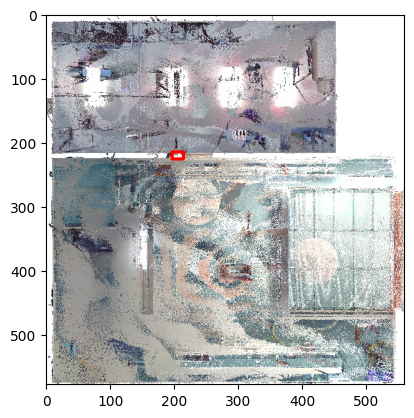

In [12]:
for n in imageNodes:
    if len(n.predictions)==0:
        continue
    
    #get point cloud
    f=next((f for f in files if n.name in f), None)
    las=laspy.read(f)
    points=o3d.utility.Vector3dVector(las.xyz)
    
    #get all predictions box center
    n.box_centers=np.array([p['box'].get_center() for p in n.predictions])

    #create point cloud from the box centers
    n.box_centers_pcd=o3d.geometry.PointCloud()
    n.box_centers_pcd.points=o3d.utility.Vector3dVector(n.box_centers)
    n.box_centers_pcd.paint_uniform_color([0,0,1])
    print(n.box_centers_pcd)
                
    #for every prediction, compute the axes between the box center and the nearest 4 points in the point cloud
    image=n.resource.copy()

    for p in n.predictions:
        #---------------------AXES FILTER---------------------------------
        #get box center
        box_center=np.array(p['box'].get_center())
        #determine neighbors
        k=10 if len(n.box_centers)>10 else len(n.box_centers)
        indices,distances=gmu.compute_nearest_neighbors(np.array([box_center]), n.box_centers, k)
        indices=indices[0]
        distances=distances[0]
        
        #get candiate points
        candidate_points=n.box_centers[indices]
        
        #compute mesh from the box
        box=o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(p['box'])
        p['mesh']=o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(box)
        p['mesh'].compute_vertex_normals()
        
        #compute the normals of the triangles        
        p['triangle_normals']=np.asarray(p['mesh'].triangle_normals)[::2] 
        
        #compute dotproduct between the candiate axes and the normals of the box. retain the biggest value
        candidate_dotproducts=[]
        for c in candidate_points:
            normalized_c=(box_center-c)/np.linalg.norm(box_center-c)
            candidate_dotproducts.append(np.abs(np.array([np.dot(normalized_c,normal) for normal in p['triangle_normals']])).max())
        candidate_dotproducts=np.array(candidate_dotproducts)

        # compute the axis for every candidate point
        candidate_axes=[]
        for c in candidate_points:
            axis=o3d.geometry.LineSet()
            axis.points=o3d.utility.Vector3dVector(np.vstack([p['box'].get_center(),c]))
            axis.lines=o3d.utility.Vector2iVector(np.array([[0,1]]))
            axis.paint_uniform_color([0,0,1])
            candidate_axes.append(axis)
        p['candidate_axes']=np.array(candidate_axes)
        
        #build mask
        mask=(distances>threshold_distance_min) & (candidate_dotproducts>threshold_angle)  & (distances<threshold_distance_max)        
        inlier_indices=indices[mask]
        
        #boost your own confidence for every axes that comply with the mask
        p['confidence_t1']=0
        for i in inlier_indices:
            p['confidence_t1']+=0.1
        
        #---------------------POINT FILTER---------------------------------
        box_expanded=gmu.expand_box(p['mesh'].get_oriented_bounding_box(),0.1,0.1,0.1)
        #crop the point cloud to the bounding box of the prediction
        pcd_indices = box_expanded.get_point_indices_within_bounding_box(points)
        
        p['score']=weight_threshold_confidence*p['confidence']+weight_threshold_confidence_t1*p['confidence_t1']/0.4+weight_threshold_point_count*len(pcd_indices)/threshold_point_count
        p['indices']=pcd_indices
        
        print(f"confidence:{p['confidence']}, confidence boost for nearby axes: {p['confidence_t1']}, confidence pcd inliers: {len(pcd_indices)/threshold_point_count}")

        
        #colorize the candidate axes that do not comply with the mask
        [i.paint_uniform_color([0,1,0]) for i in p['candidate_axes'][mask]]
        
        #colorize image with the axes        
        x = int(p['x']/n.scale)
        y = int(p['y']/n.scale)
        width = int(p['width']/n.scale)
        height = int(p['height']/n.scale)
        cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (0, 255, 0), 3) if p['score']>threshold_confidence else cv2.rectangle(image, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (255, 0, 0), 3)
        #draw the axes
        for i,c in enumerate(p['candidate_axes']):
            p1=(x,y)
            p2=(int(n.predictions[indices[i]]['x']/n.scale),int(n.predictions[indices[i]]['y']/n.scale))
            cv2.line(image, p1, p2, (0, 255, 0), 2) if indices[i] in inlier_indices else cv2.line(image, p1, p2, (255, 0, 0), 1)
            
    plt.imshow(image)
    #write the image to a file
    image_path = results_folder / f'{n.name}_predictions.png'
    cv2.imwrite(str(image_path), image)

In [13]:
# joined_pcd=gmu.join_geometries([n.resource.paint_uniform_color(n.color) for n in pcdNodes if n.resource is not None])
# o3d.visualization.draw_geometries([pcd]+[p['box'] for p in n.predictions])

visualize results

In [14]:
# for n in imageNodes[0:1]:
#     joined_axes=gmu.join_geometries([p['candidate_axes'].tolist() for p in n.predictions])
#     #get a slice of the pcd point cloud
#     z_min=pcd.get_center()[2]
#     z_max=z_min+1
#     slice_pcd=t2.slice_point_cloud(pcd, z_min, z_max)
    
#     # candidate_axes=gmu.join_geometries([p['candidate_axes'].tolist() for p in n.predictions])
#     test=[p['candidate_axes'].tolist() for p in n.predictions]
#     candidate_axes=[item for sublist in test for item in sublist]
    

#     for p in n.predictions:
#         #create colorgradient from red to green for the score
#         color=[1-p.score, p.score, 0]
#         p['mesh'].paint_uniform_color(color)
#         if p.score<threshold_score:
#             p['mesh'].paint_uniform_color([0.3,0.3,0.3])

#     meshes=gmu.join_geometries([p['mesh'] for p in n.predictions])
    
#     o3d.visualization.draw_geometries([slice_pcd]+[meshes]+candidate_axes)

## EXPORT RESULTS

assign class labels to point clouds

In [15]:
for n in imageNodes:
    if len(n.predictions)==0:
        continue
    
    #get point cloud
    f=next((f for f in files if n.name in f), None)
    las=laspy.read(f)
    las.point_format.dimension_names
    if 'classes' in list(las.point_format.dimension_names) and 'objects' in list(las.point_format.dimension_names):
        classArray=las['classes'] 
        objectArray=las['objects']   
    else:
        classArray=np.zeros(las.xyz.shape[0])
        objectArray=np.zeros(las.xyz.shape[0])
        gmu.las_add_extra_dimensions(las,[classArray,objectArray], ['classes','objects'],dtypes=[np.uint8,np.uint16] )
        
    for i,p in enumerate(n.predictions):
        if p['score']>=threshold_confidence:
            #replace classArray[indices] with the class of the prediction ==2
            las.classes[p['indices']]=2
            las.objects[p['indices']]=i+200
    #export las
    las.write(results_folder / f'{n.name}_predictions.laz')    